# [**Catch me if you can**](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2)

#### Session: Fall 2019

## Kaggle inclass competition from [mlcourse.ai](https://mlcourse.ai/)

Author: Vladimir Kulyashov

creation date: 15 October 2019

In [178]:
# imports and constants
import os
import pickle
import numpy as np
import pandas as pd
import time
from contextlib import contextmanager
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt


PATH_TO_DATA = 'E:/ods_mlcourse/data/alice/'
AUTHOR = 'Vladimir_Kulyashov'

# most of hyperparams here

vectorizer_params={'ngram_range': (1, 5),
                   'max_features': 50000,
                   'tokenizer': lambda s: s.split()}
SEED = 17
N_JOBS = 4
NUM_TIME_SPLITS = 10    # for time-based cross-validation
SITE_NGRAMS = (1, 5)    # site ngrams for "bag of sites"
MAX_FEATURES = 50000    # max features for "bag of sites"
BEST_LOGIT_C = 5.45559  # precomputed tuned C for logistic regression

### Useful def's from public notebooks

In [190]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio=0.9):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, solver='liblinear').fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [46]:
%%time
# Read the training and test data sets, change paths if needed

times = ['time%s' % i for i in range(1, 11)]
train_df = pd.read_csv(PATH_TO_DATA + 'train_sessions.csv',
                       index_col='session_id', parse_dates=times)
test_df = pd.read_csv(PATH_TO_DATA + 'test_sessions.csv',
                      index_col='session_id', parse_dates=times)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Look at the first rows of the training set
train_df.head(3)

Wall time: 3.91 s


,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0


In [47]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype(np.uint16)
test_df[sites] = test_df[sites].fillna(0).astype(np.uint16)

# Load websites dictionary
with open(PATH_TO_DATA + 'site_dic.pkl', "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), 
                          columns=['site'])
print(u'Websites total:', sites_dict.shape[0])
sites_dict.head(3)

Websites total: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com


### Exploratory Data Analysis

In [187]:
# Top websites in the training data set
top_sites = pd.Series(train_df[sites].values.flatten()
                     ).value_counts().sort_values(ascending=False).head(15)
print(top_sites)
sites_dict.loc[top_sites.drop(0).index]

21     123776
0      122730
23      87619
782     77055
22      58258
29      54094
167     46405
780     43841
778     38194
52      36085
812     35178
80      31391
570     30616
55      27812
39      25275
dtype: int64


,site
21,www.google.fr
23,www.google.com
782,annotathon.org
22,apis.google.com
29,www.facebook.com
167,www.bing.com
780,blast.ncbi.nlm.nih.gov
778,www.ncbi.nlm.nih.gov
52,clients1.google.com
812,mail.google.com


In [188]:
top_alice_sites = pd.Series(train_df[train_df['target'] == 1][sites].values.flatten()
                     ).value_counts().sort_values(ascending=False).head(15)
sites_dict.loc[top_alice_sites.index]

,site
77,i1.ytimg.com
80,s.youtube.com
76,www.youtube.com
29,www.facebook.com
21,www.google.fr
81,r4---sn-gxo5uxg-jqbe.googlevideo.com
879,r1---sn-gxo5uxg-jqbe.googlevideo.com
22,apis.google.com
75,s.ytimg.com
82,r2---sn-gxo5uxg-jqbe.googlevideo.com


In [52]:
# Create a separate dataframe where we will work with timestamps
time_df = pd.DataFrame(index=train_df.index)
time_df['target'] = train_df['target']

# Find sessions' starting and ending
time_df['start'] = train_df[times].min(axis=1)
time_df['finish'] = train_df[times].max(axis=1)

# Calculate sessions' duration in seconds
time_df['seconds'] = (time_df['finish'] - time_df['start']) / np.timedelta64(1, 's')

time_df.head(3)

,target,start,finish,seconds
session_id,,,,
21669,0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0
54843,0,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0
77292,0,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0


In [ ]:
# Our target variable
y_train = train_df['target']

# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]

In [ ]:
# Dataframe with indices of visited websites in session
full_sites = full_df[sites]
full_sites.head()

In [ ]:
# sequence of indices
sites_flatten = full_sites.values.flatten()

# and the matrix we are looking for 
# (make sure you understand which of the `csr_matrix` constructors is used here)
# a further toy example will help you with it
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0]  + 10, 10)))[:, 1:]

In [189]:
# plt.hist(time_df[(time_df['target']==1) & (time_df['seconds']<100)]['seconds']);
# alice_sessions = time_df[time_df['target']==1].sort_values(['start'])
# number_of_alice_sessions = time_df[time_df['target']==1]['target'].count()
# alice_sessions['seconds'].describe()
# # time_df[(time_df['target']==1) & (time_df['seconds'] >=300)]['target'].count()

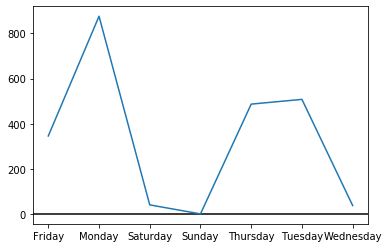

In [151]:
# alice_sessions['day'] = alice_sessions['start'].apply(lambda t: t.weekday())
number_of_sessions_by_weekdays = alice_sessions.groupby(
    alice_sessions['start'].apply(lambda t: t.day_name()))['seconds'].count()
duration_of_sessions_by_weekdays = alice_sessions.groupby(
    alice_sessions['start'].apply(lambda t: t.day_name()))['seconds'].sum()

plt.hlines(0, -1, 7)
plt.plot(number_of_sessions_by_weekdays);

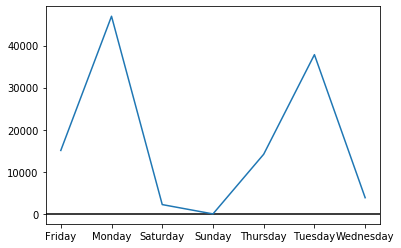

In [150]:
plt.hlines(0, -1, 7)
plt.plot(duration_of_sessions_by_weekdays);

### New Features

In [191]:
# Dataframe for new features
full_new_feat = pd.DataFrame(index=full_df.index)

# start_month
full_new_feat['start_month'] = full_df['time1'].apply(lambda ts: 
                                                      100 * ts.year + ts.month).astype('float64')
# n_unique_sites
full_new_feat['n_unique_sites'] = full_sites.nunique(axis=1)

# start_hour
full_new_feat['start_hour'] = full_df['time1'].apply(lambda ts: ts.hour)

# start_minute
full_new_feat['start_minute'] = full_df['time1'].apply(lambda ts: ts.minute)

# morning
full_new_feat['morning'] = ((full_new_feat['start_hour'] >= 0) & (full_new_feat['start_hour'] <= 11)).astype(int)


In [192]:
# Add the new features to the sparse matrix
tmp = full_new_feat.values
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

,start_month,n_unique_sites,start_hour,start_minute,morning
session_id,,,,,
21669,201301.0,3,8,5,1
54843,201301.0,3,8,37,1
77292,201301.0,6,8,50,1
114021,201301.0,5,8,50,1
146670,201301.0,6,8,50,1
...,...,...,...,...,...
82793,201410.0,4,18,20,0
82794,201405.0,6,14,16,0
82795,201405.0,10,11,21,1


### Training model

In [ ]:
time_split = TimeSeriesSplit(n_splits=NUM_TIME_SPLITS)
logit = LogisticRegression(random_state=SEED, solver='liblinear')

# I've done cross-validation locally, and do not reproduce these heavy computations here,
# but this is the vest C that I've found
c_values = [BEST_LOGIT_C]

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                              scoring='roc_auc', n_jobs=N_JOBS, cv=time_split, verbose=1)
logit_grid_searcher.fit(X_train_final, y_train)
print('CV score', logit_grid_searcher.best_score_)

In [185]:
# '''
# This is a template for your reproducible solution in the Alice competition.
# It's obligatory that your script produces a submission file just 
# by running `python solution_alice_<name>_<surname>.py`. 
# If you have any dependecies apart from those in a Kaggle Docker image, 
# it's your responsibility to provide an image (or at least a requirements file) 
# to reproduce your solution.

# Please avoid heavy hyperparameter optimization in this script. 

# IMPORTANT: this script is to be shared only with organizers, as described in the
# course roadmap https://mlcourse.ai/roadmap. Be careful not to share it in 
# Kaggle Kernels, don't spoil the competitive spirit. 
# '''


 

# # nice way to report running times
# @contextmanager
# def timer(name):
#     t0 = time.time()
#     yield
#     print(f'[{name}] done in {time.time() - t0:.0f} s')


# with timer('Building sparse site features'):
#     X_train_sites, X_test_sites, y_train, vectorizer, train_times, test_times = \
#         prepare_sparse_features(
#             path_to_train=os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
#             path_to_test=os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
#             path_to_site_dict=os.path.join(PATH_TO_DATA, 'site_dic.pkl'),
#             vectorizer_params={'ngram_range': SITE_NGRAMS,
#                                'max_features': MAX_FEATURES,
#                                'tokenizer': lambda s: s.split()})


# with timer('Building additional features'):
#     X_train_final = add_features(train_times, X_train_sites)
#     X_test_final = add_features(test_times, X_test_sites)


# with timer('Cross-validation'):
#     time_split = TimeSeriesSplit(n_splits=NUM_TIME_SPLITS)
#     logit = LogisticRegression(random_state=SEED, solver='liblinear')

#     # I've done cross-validation locally, and do not reproduce these heavy computations here,
#     # but this is the best C that I've found
#     c_values = BEST_LOGIT_C

#     logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
#                                   scoring='roc_auc', n_jobs=N_JOBS, cv=time_split, verbose=1)
#     logit_grid_searcher.fit(X_train_final, y_train)
#     print('CV score', logit_grid_searcher.best_score_)
#     print('Best params', logit_grid_searcher.best_params_)

# with timer('Test prediction and submission'):
#     test_pred = logit_grid_searcher.predict_proba(X_test_final)[:, 1]
#     pred_df = pd.DataFrame(test_pred, index=np.arange(1, test_pred.shape[0] + 1),
#                        columns=['target'])
#     pred_df.to_csv(f'submission_alice_{AUTHOR}_3.csv', index_label='session_id')



[Building sparse site features] done in 38 s
[Building additional features] done in 8 s
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  7.5min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 18.0min finished


CV score 0.878687949749715
Best params {'C': 29876366.45816604}
[Cross-validation] done in 1156 s
[Test prediction and submission] done in 0 s
